Dataset loaded.
Column 'Respondent sequence number':
  Unique values: [ 93705.  93706.  93708. ... 102953. 102954. 102956.] (count: 5533)
  Missing values: 0

Column 'Have little interest in doing things':
  Unique values: [5.39760535e-79 1.00000000e+00 3.00000000e+00 2.00000000e+00
 7.00000000e+00 9.00000000e+00] (count: 6)
  Missing values: 439

Column 'Feeling down, depressed, or hopeless':
  Unique values: [5.39760535e-79 1.00000000e+00 3.00000000e+00 2.00000000e+00
 9.00000000e+00 7.00000000e+00] (count: 6)
  Missing values: 440

Column 'Trouble sleeping or sleeping too much':
  Unique values: [5.39760535e-79 1.00000000e+00 2.00000000e+00 3.00000000e+00
 9.00000000e+00 7.00000000e+00] (count: 6)
  Missing values: 440

Column 'Feeling tired or having little energy':
  Unique values: [5.39760535e-79 1.00000000e+00 3.00000000e+00 2.00000000e+00
 9.00000000e+00 7.00000000e+00] (count: 6)
  Missing values: 441

Column 'Poor appetite or overeating':
  Unique values: [5.39760535e-79 1.00

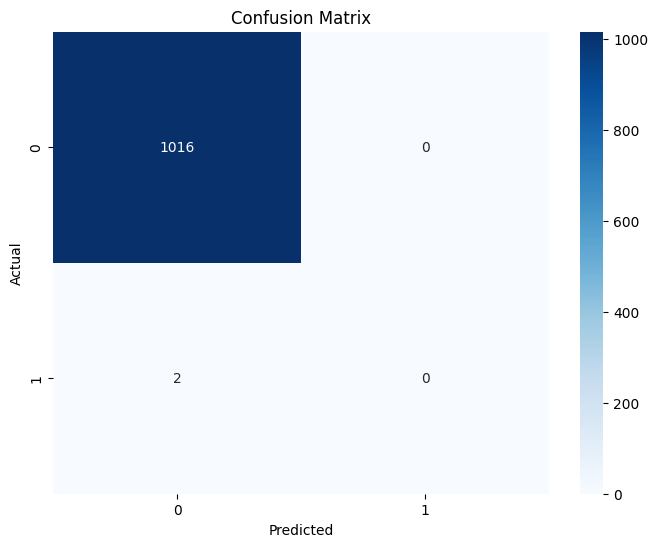

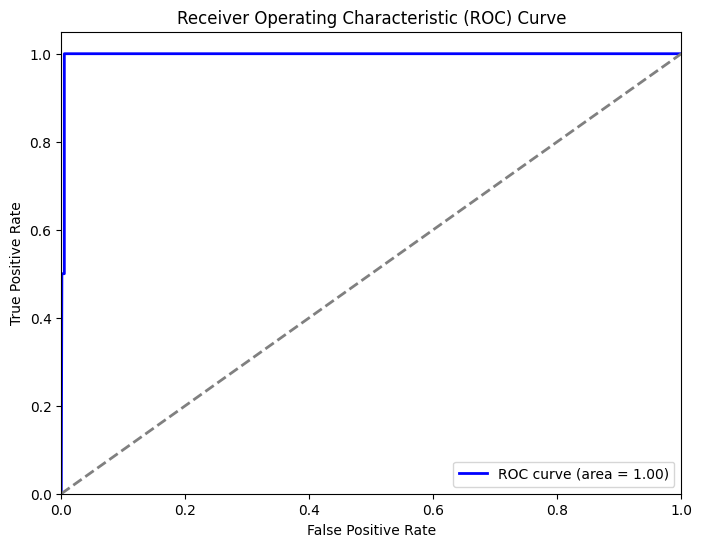

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Load the dataset
df = pd.read_sas('./DPQ_J.XPT')
print("Dataset loaded.")

# 2. Rename the columns
new_column_names = {
    'SEQN': 'Respondent sequence number',
    'DPQ010': 'Have little interest in doing things',
    'DPQ020': 'Feeling down, depressed, or hopeless',
    'DPQ030': 'Trouble sleeping or sleeping too much',
    'DPQ040': 'Feeling tired or having little energy',
    'DPQ050': 'Poor appetite or overeating',
    'DPQ060': 'Feeling bad about yourself',
    'DPQ070': 'Trouble concentrating on things',
    'DPQ080': 'Moving or speaking slowly or too fast',
    'DPQ090': 'Thought you would be better off dead',
    'DPQ100': 'Difficulty these problems have caused'
}
df.rename(columns=new_column_names, inplace=True)

# 3. Display unique and missing values for each column
def unique_and_missing_values(df):
    for col in df.columns:
        unique_values = df[col].dropna().unique()
        missing_count = df[col].isna().sum()
        print(f"Column '{col}':")
        print(f"  Unique values: {unique_values} (count: {len(unique_values)})")
        print(f"  Missing values: {missing_count}\n")

unique_and_missing_values(df)

# 4. Remove columns with too many missing values and unnecessary columns
df = df.drop(columns=['Difficulty these problems have caused', 'Respondent sequence number'])

# 5. Drop rows with missing values
df = df.dropna()

# 6. Replace all occurrences of 5.397605e-79 with 0
df = df.astype(int)

# 7. Binarize the target column
df['Feeling down, depressed, or hopeless'] = df['Feeling down, depressed, or hopeless'].apply(lambda x: 1 if x > 4.5 else 0)

# 8. Save the cleaned data to a CSV file
df.to_csv('modified_data.csv', index=False)
print("Cleaned data saved to 'modified_data.csv'.")

# 9. Display unique and missing values for each column after cleaning
unique_and_missing_values(df)

# 10. Split the data into features (X) and target (y)
X = df.drop(columns=['Feeling down, depressed, or hopeless'])
y = df['Feeling down, depressed, or hopeless']

# 11. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 12. Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 13. Train an SVM model with RBF kernel
svm_model = SVC(kernel='rbf', probability=True)
svm_model.fit(X_train_scaled, y_train)
print("Model training completed.")

# 14. Make predictions
y_pred = svm_model.predict(X_test_scaled)
y_prob = svm_model.predict_proba(X_test_scaled)[:, 1]

# 15. Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print(f'Accuracy: {accuracy:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')

# 16. Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 17. Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
